In [1]:
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import linregress

In [11]:
df = pd.read_csv('../zippedData/combined.csv',index_col=0)

In [12]:
#create a dictionary to see count
def genre_counter(dataframe):
    '''
    returns a dictionary of counts by iterating over dataframe['genre_list']
    '''
    
    m = {}
    for i in dataframe['genre_list']:
        for x in i:
            if x not in m:
                m[x] = 1
            else:
                m[x] += 1
    
    
    sorted_m = {k: v for k,v in sorted(m.items(), key=lambda item: item[1], reverse=True)}
    
    return sorted_m

In [13]:
def cleaned_genre(dataframe):
    '''
    returns dataframe with genre dummy columns.
    genres to keep:['Horror', 'Mystery', 'Thriller', 'Action', 'Adventure', 'Western',
                    'Biography', 'Drama', 'History', 'War', 'Comedy', 'Romance',
                    'Family', 'Fantasy', 'Sci-Fi', 'Crime', 'Music', 'Sport', 'Musical', 'Animation']
    '''
    

    dataframe.dropna(subset=['genre'],axis=0,inplace=True)                               #drop rows with missing genre
    dataframe.reset_index(drop=True,inplace=True)                                        #need to reset_index before we select drop
    
    dataframe.drop(dataframe[dataframe['genre'].str.contains('See All')].index,axis=0,inplace=True)    #drop rows with genre containing 'Adult' or 'See All'
    dataframe.drop(dataframe[dataframe['genre'].str.contains('Adult')].index,axis=0,inplace=True)      #7 rows with genre containing 'Adult' or 'See All'
    dataframe.reset_index(drop=True,inplace=True)
    
    
    _list = []
    for i in dataframe['genre']:        #genre column contains list-like strings
        _list.append(ast.literal_eval(i))   #ast can convert these strings into actual lists
    
    
    dataframe['genre_list'] = _list
    
    # m will return dict- key(genre) with value(count)
    m = genre_counter(dataframe)
    genre_category = list(m.keys())
    
    #creating dummy variables with 0
    for i in genre_category:
        dataframe[i] = 0
    
    print('iterating over 18288 rows')
    for i, x in tqdm(enumerate(dataframe['genre_list'])):
        for each in x:
            dataframe.loc[i, each] = 1
    print('done')
    
    
    return dataframe

In [14]:
def cleaned_gross_minus_budget(dataframe):
    '''
    returns cleaned dataframe by: dropping rows with missing 'budget' and 'worldwide-gross'
    new column created 'gross_minus_budget' representing net
    '''
    _df = cleaned_genre(dataframe)
    combined = _df.copy()
    
    combined['worldwide_gross'] = combined['worldwide_gross'].str.strip('$')
    combined['worldwide_gross'] = combined['worldwide_gross'].str.replace(',', '')

    combined['budget'] = combined['budget'].str.strip('$')
    combined['budget'] = combined['budget'].str.replace(',', '')

    combined['gross_usa'] = combined['gross_usa'].str.strip('$')
    combined['gross_usa'] = combined['gross_usa'].str.replace(',', '')
    
    
    combined = combined[~combined['budget'].astype(str).str.startswith('SEK')]
    combined = combined[~combined['budget'].astype(str).str.startswith('NOK')]
    combined = combined[~combined['budget'].astype(str).str.startswith('KRW')]
    combined = combined[~combined['budget'].astype(str).str.startswith('SGD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('THB')]
    combined = combined[~combined['budget'].astype(str).str.startswith('JPY')]
    combined = combined[~combined['budget'].astype(str).str.startswith('HUF')]
    combined = combined[~combined['budget'].astype(str).str.startswith('INR')]
    combined = combined[~combined['budget'].astype(str).str.startswith('GBP')]
    combined = combined[~combined['budget'].astype(str).str.startswith('HKD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('FRF')]
    combined = combined[~combined['budget'].astype(str).str.startswith('EUR')]
    combined = combined[~combined['budget'].astype(str).str.startswith('FIM')]
    combined = combined[~combined['budget'].astype(str).str.startswith('DEM')]
    combined = combined[~combined['budget'].astype(str).str.startswith('DKK')]
    combined = combined[~combined['budget'].astype(str).str.startswith('CAD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('ESP')]
    combined = combined[~combined['budget'].astype(str).str.startswith('AUD')]
    combined = combined[~combined['budget'].astype(str).str.startswith('BEF')]
    combined = combined[~combined['budget'].astype(str).str.startswith('CNY')]
    combined = combined[~combined['budget'].astype(str).str.startswith('ATS')]
    combined = combined[~combined['budget'].astype(str).str.startswith('BRL')]
    combined = combined[~combined['budget'].astype(str).str.startswith('BRL')]
    combined = combined[~combined['budget'].astype(str).str.startswith('ITL')]
    combined = combined[~combined['budget'].astype(str).str.startswith('RUR')]
    combined = combined[~combined['budget'].astype(str).str.startswith('IEP')]
    combined = combined[~combined['budget'].astype(str).str.startswith('TRL')]
    
    _albert = combined.dropna(subset=['budget','worldwide_gross'],axis=0).copy()
    _albert['budget'] = _albert['budget'].astype('int64')
    _albert['worldwide_gross'] = _albert['worldwide_gross'].astype('int64')
    
    _albert['gross_minus_budget'] = _albert['worldwide_gross'] - _albert['budget']
    
    print('dropped 11889 rows. final shape: ',_albert.shape)
    return _albert

In [15]:
def find_linregress_slope_dist(dataframe):
    '''
    x = years, y = percentage of movies that contain genre
    returns a list of tuples with slope, genre.
    ex: [(0.005,Thriller),(0.004,Drama)...]
    '''
    m = genre_counter(dataframe)
    genre_category = list(m.keys())
    
    _albert = []
    for i in genre_category:
        _sample_df = dataframe.groupby(['year'])[i].mean().reset_index()
        _linregress = linregress(_sample_df['year'], _sample_df[i])[0]
        _albert.append((_linregress,i))
    
    _albert.sort(key = lambda x: x[0], reverse = True)
    return _albert

In [16]:
def plot_genre_distribution(m):
    plt.figure(figsize=(20,10))
    plt.bar(list(m.keys()), m.values())
    plt.ylabel('Frequency')
    plt.xlabel('Genres')
    plt.title('Genre Distribution of Top 300 movies between years 1960 to 2020')
    plt.show()

In [17]:
_genre = cleaned_genre(df)

120it [00:00, 1183.26it/s]

iterating over 18288 rows


18288it [00:14, 1224.71it/s]

done


In [18]:

m = genre_counter(_genre)

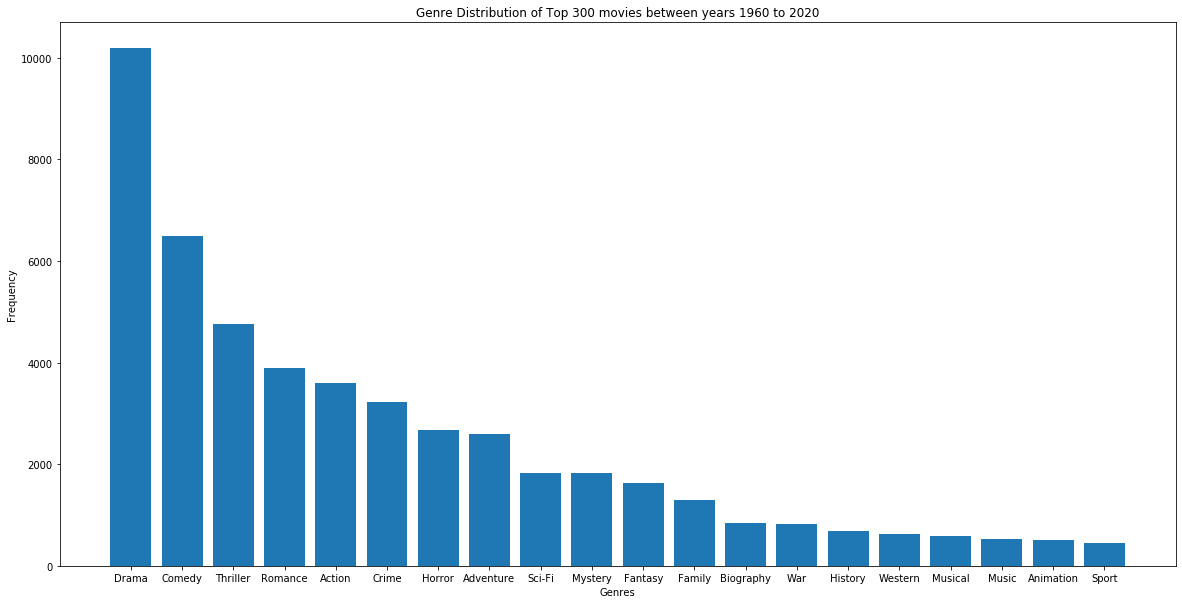

In [19]:
plot_genre_distribution(m)

In [20]:
def plot_top_worst_dist(dataframe):
    
    _linregress = find_linregress_slope_dist(dataframe)
    

    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
    ax_1 = axes[0]
    _df = dataframe.groupby(['year'])[_linregress[0][1]].mean()
    sns.regplot(x=list(_df.index), y=_df.values, ax= ax_1)
    ax_1.set_ylabel('Percentage')
    ax_1.set_title('Highest Distribution: '+_linregress[0][1])
    ax_1.set_ylim(0,0.7)

    ax_2 = axes[1]
    _df = dataframe.groupby(['year'])[_linregress[-1][1]].mean()
    sns.regplot(x=list(_df.index), y=_df.values, ax= ax_2)
    ax_2.set_ylabel('Percentage')
    ax_2.set_title('Lowest Distribution: '+_linregress[-1][1])
    ax_2.set_ylim(0,0.7)

    fig.suptitle('High/Low Distribution of Genres from 1960 to 2020');

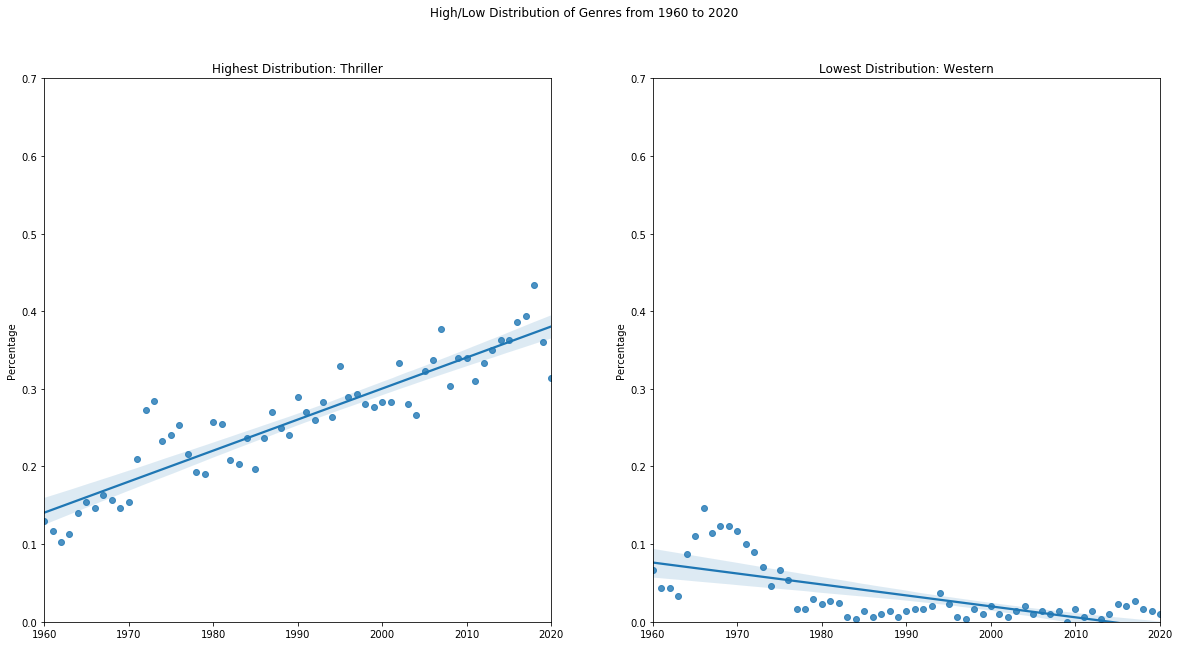

In [21]:
plot_top_worst_dist(_genre)

In [22]:
cleaned_gross = cleaned_gross_minus_budget(df)

280it [00:00, 1356.83it/s]

iterating over 18288 rows


18288it [00:14, 1224.97it/s]


done
dropped 11889 rows. final shape:  (6399, 32)


In [23]:
def find_linregress_slope_dist(dataframe):
    '''
    x = years, y = percentage of movies that contain genre
    returns a list of tuples with slope, genre.
    ex: [(0.005,Thriller),(0.004,Drama)...]
    '''
    m = genre_counter(dataframe)
    genre_category = list(m.keys())
    
    _albert = []
    for i in genre_category:
        _sample_df = dataframe.groupby(['year'])[i].mean().reset_index()
        _linregress = linregress(_sample_df['year'], _sample_df[i])[0]
        _albert.append((_linregress,i))
    
    _albert.sort(key = lambda x: x[0], reverse = True)
    return _albert

In [24]:
def find_linregress_slope_gross(dataframe):
    '''
    x = years, y = gross_minus_budget
    returns a list of tuples with slope, genre.
    ex: [(4428902,Thriller),(125214,Drama)...]
    '''
    m = genre_counter(dataframe)
    genre_category = list(m.keys())
    
    _albert = []
    for i in genre_category:
        _albert_yes = dataframe.loc[dataframe[i] == 1]
        _sample_df = _albert_yes.groupby(['year'])['gross_minus_budget'].mean().reset_index()
        _linregress = linregress(_sample_df['year'], _sample_df['gross_minus_budget'])[0]
        _albert.append((_linregress,i))
    
    _albert.sort(key = lambda x: x[0], reverse = True)
    return _albert

In [25]:
gross_slope = find_linregress_slope_gross(cleaned_gross)

In [26]:
gross_slope

[(4428902.01593712, 'Animation'),
 (4392300.607497364, 'Musical'),
 (3905571.592722525, 'Adventure'),
 (3364200.4461238435, 'Fantasy'),
 (3304892.017566035, 'Sci-Fi'),
 (2689759.9678901974, 'Family'),
 (2357560.010897966, 'Action'),
 (1665891.8092986054, 'Music'),
 (1500153.499897386, 'Comedy'),
 (1364146.177246614, 'Mystery'),
 (1091141.068143111, 'Thriller'),
 (1021392.3278442413, 'War'),
 (975584.9045584836, 'Romance'),
 (880651.0098206727, 'Crime'),
 (870414.6509338833, 'History'),
 (718899.579357285, 'Horror'),
 (629027.9987008005, 'Drama'),
 (375519.70506954344, 'Western'),
 (183812.47464667555, 'Sport'),
 (76771.23079767723, 'Biography')]

In [27]:
albert_trimmed = cleaned_gross.copy()

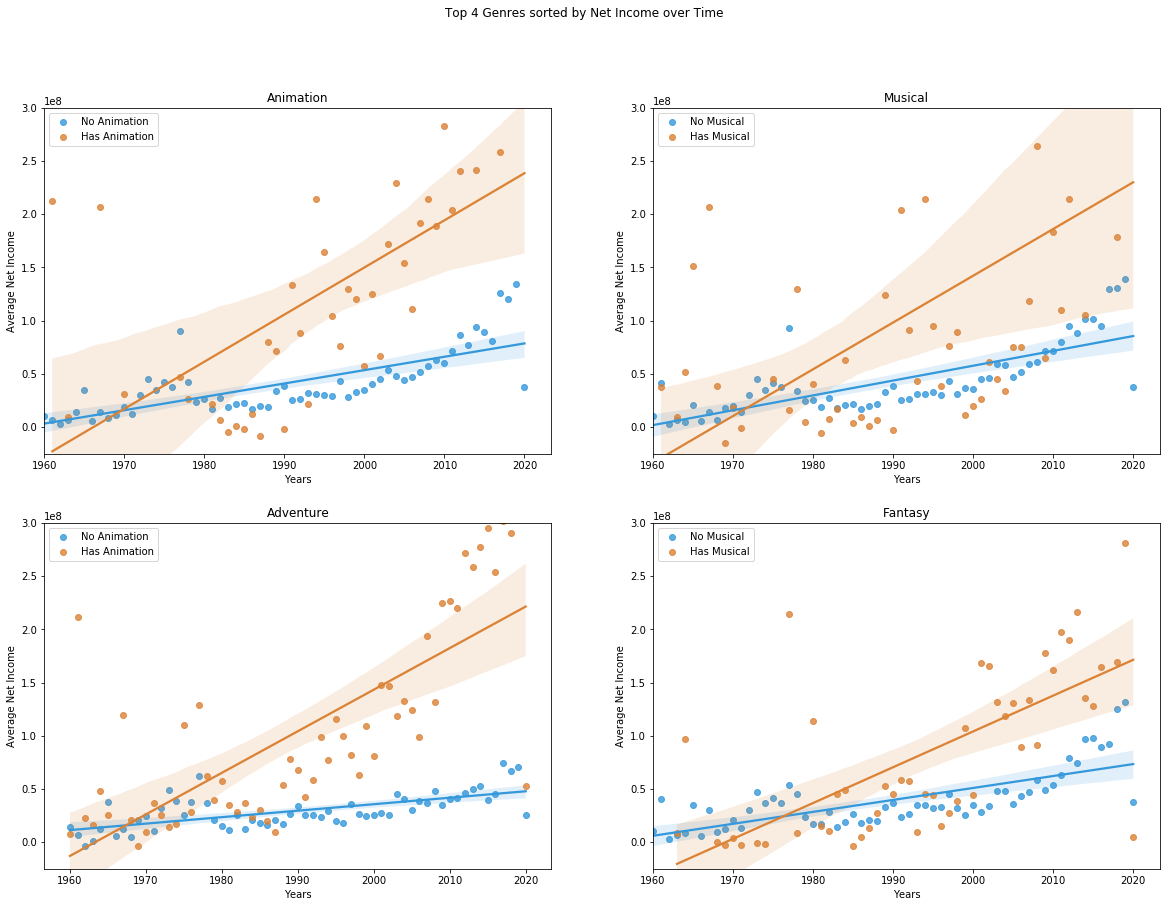

In [28]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,14))
ax_1 = axes[0][0]
_albert_no0 = albert_trimmed.loc[albert_trimmed[gross_slope[0][1]] == 0]
_albert_yes0 = albert_trimmed.loc[albert_trimmed[gross_slope[0][1]] == 1]


_nodf = _albert_no0.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_nodf.index), y=_nodf.values,label='No {}'.format(gross_slope[0][1]), ax= ax_1, color="#3498db")
_df = _albert_yes0.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_df.index), y=_df.values,label='Has {}'.format(gross_slope[0][1]), ax= ax_1, color = "#db8234")
ax_1.legend(loc='upper left')
ax_1.set_ylabel('Average Net Income')
ax_1.set_title(gross_slope[0][1])
ax_1.set_ylim(-25_000_000,300_000_000)
ax_1.set_xlabel('Years')


ax_2 = axes[0][1]
_albert_no1 = albert_trimmed.loc[albert_trimmed[gross_slope[1][1]] == 0]
_albert_yes1 = albert_trimmed.loc[albert_trimmed[gross_slope[1][1]] == 1]

_nodf = _albert_no1.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_nodf.index), y=_nodf.values,label='No {}'.format(gross_slope[1][1]), ax= ax_2, color="#3498db")
_df = _albert_yes1.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_df.index), y=_df.values,label='Has {}'.format(gross_slope[1][1]), ax= ax_2, color = "#db8234")
ax_2.legend(loc='upper left')
ax_2.set_ylabel('Average Net Income')
ax_2.set_title(gross_slope[1][1])
ax_2.set_ylim(-25_000_000,300_000_000)
ax_2.set_xlabel('Years')



ax_3 = axes[1][0]
_albert_no0 = albert_trimmed.loc[albert_trimmed[gross_slope[2][1]] == 0]
_albert_yes0 = albert_trimmed.loc[albert_trimmed[gross_slope[2][1]] == 1]


_nodf = _albert_no0.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_nodf.index), y=_nodf.values,label='No {}'.format(gross_slope[0][1]), ax= ax_3, color="#3498db")
_df = _albert_yes0.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_df.index), y=_df.values,label='Has {}'.format(gross_slope[0][1]), ax= ax_3, color = "#db8234")
ax_3.legend(loc='upper left')
ax_3.set_ylabel('Average Net Income')
ax_3.set_title(gross_slope[2][1])
ax_3.set_ylim(-25_000_000,300_000_000)
ax_3.set_xlabel('Years')


ax_4 = axes[1][1]
_albert_no1 = albert_trimmed.loc[albert_trimmed[gross_slope[3][1]] == 0]
_albert_yes1 = albert_trimmed.loc[albert_trimmed[gross_slope[3][1]] == 1]


_nodf = _albert_no1.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_nodf.index), y=_nodf.values,label='No {}'.format(gross_slope[1][1]), ax= ax_4, color="#3498db")
_df = _albert_yes1.groupby(['year'])['gross_minus_budget'].mean()
sns.regplot(x=list(_df.index), y=_df.values,label='Has {}'.format(gross_slope[1][1]), ax= ax_4, color = "#db8234")
ax_4.legend(loc='upper left')
ax_4.set_ylabel('Average Net Income')
ax_4.set_title(gross_slope[3][1])
ax_4.set_ylim(-25_000_000,300_000_000)

ax_4.set_xlabel('Years')
fig.suptitle('Top 4 Genres sorted by Net Income over Time');